# Machine Learning and Statistics for Physicists

**This notebook is still in development.**

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

We will use the sklearn [decomposition module](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) below:

In [146]:
from sklearn import neighbors, mixture

## Background

In [3]:
import scipy.stats

In [203]:
model1 = lambda theta: scipy.stats.multivariate_normal([theta, 0.], [[1., -1], [-1, 2.]])

In [199]:
model2 = lambda theta: scipy.stats.multivariate_normal([0., 0.], [[np.exp(theta), -np.exp(theta/2)], [-np.exp(theta/2), 2.]])

In [200]:
model3 = lambda theta: scipy.stats.multivariate_normal([theta, 0.], [[np.exp(theta), -np.exp(theta/2)], [-np.exp(theta/2), 2.]])

In [7]:
def grid_list(*grids):
    D = len(grids)
    shape = [len(grid) for grid in grids] + [D]
    G = np.empty(shape)
    axis_shape = np.ones(D, dtype=int)
    axis_shape[0] = -1
    for d in range(D):
        G[...,d] = np.reshape(grids[d], axis_shape)
        axis_shape = np.roll(axis_shape, 1)
    return G

In [59]:
def compress(X, mu, C_inv, mu_grad, C_grad):
    D = len(mu)
    delta = X.reshape(-1, D) - mu
    Cd = C_inv.dot(delta.T)
    t_linear = mu_grad.T.dot(Cd)
    t_quad = 0.5 * np.sum(delta * (C_inv.dot(C_grad.dot(Cd))).T, axis=1)
    return t_linear + t_quad

In [230]:
def study(model, theta0, dtheta, theta_min, theta_max, tobs, bw,
          xlim=5, ngrid=100, ngen=1000, nprior=10000, nsig=3., seed=123):
    # Create the base and perturbed models.
    M0 = model(theta0)
    Mp = model(theta0 + dtheta)
    Mm = model(theta0 - dtheta)
    # Define the plot region.
    x = np.linspace(-xlim, +xlim, ngrid)
    x12 = grid_list(x, x)
    # Calculate the -log(likelihood) for the models.
    NLL0 = -M0.logpdf(x12).T + M0.logpdf(M0.mean)
    NLLp = -Mp.logpdf(x12).T + Mp.logpdf(Mp.mean)
    NLLm = -Mm.logpdf(x12).T + Mm.logpdf(Mm.mean)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    ax = axes[0]
    # Plot the base model NLL.
    ##plt.imshow(NLL0, interpolation='none', extent=[-xlim, xlim, -xlim, xlim], origin='lower')
    # Plot the n-sigma contour and mean of the base model.
    ax.contour(x, x, NLL0, levels=[nsig], colors='g', zorder=10, linewidths=2, alpha=0.85)
    #ax.scatter(*M0.mean, marker='+', s=100, c='b', zorder=10)
    # Plot n-sigma contours of the perturbed models.
    ax.contour(x, x, NLLp, levels=[nsig], colors='g', zorder=10, linewidths=2, linestyles='--')
    ax.contour(x, x, NLLm, levels=[nsig], colors='g', zorder=10, linewidths=2, linestyles=':')
    ax.plot([], [], 'g:', lw=2, label=f'$\\theta={theta0-dtheta:.1f}$')
    ax.plot([], [], 'g-', lw=2, label=f'$\\theta={theta0:.1f}$')
    ax.plot([], [], 'g--', lw=2, label=f'$\\theta={theta0+dtheta:.1f}$')
    ax.legend()
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # Estimate the gradients of mu, C wrt to theta, evaluated at theta0.
    mu_grad = (Mp.mean - Mm.mean) / (2 * dtheta)
    C_grad = (Mp.cov - Mm.cov) / (2 * dtheta)
    C_inv = np.linalg.inv(M0.cov)
    
    # Generate some samples from the base model.
    gen = np.random.RandomState(seed)
    X = M0.rvs(ngen, gen)

    # Calculate the quadratic function of (x1,x2) that "optimally" compresses
    # the information available about theta (assuming theta ~ theta0).
    t = compress(x12, M0.mean, C_inv, mu_grad, C_grad)
    t = t.reshape(ngrid, ngrid).T
    
    I = ax.imshow(t, interpolation='none', origin='lower', extent=[-xlim, xlim, -xlim, xlim], zorder=-10)
    #plt.colorbar(I, ax=ax)
    
    # Plot contours of constant t.
    CS = ax.contour(x, x, t, colors='w', linestyles='-', linewidths=1, alpha=0.75)
    plt.clabel(CS, inline=1, fontsize=11, fmt='%+.1f')
    
    # Plot the generated samples, colored according to t.
    #t = compress(X, M0.mean, C_inv, mu_grad, C_grad)
    #vmin, vmax = np.percentile(t, (2.5, 97.5))
    #ax.scatter(X[:, 0], X[:, 1], lw=0, c=t, s=15, vmin=vmin, vmax=vmax)
    ax.scatter(X[:, 0], X[:, 1], lw=0, c='gray', s=5)
    
    ax.set_xlim(-xlim, +xlim)
    ax.set_ylim(-xlim, +xlim)
    ax.set_aspect(1)
    ax.grid(False)
    
    # Generate samples from the parameter prior.
    theta = gen.uniform(theta_min, theta_max, size=nprior)
    # Generate one realization of the data (x1,x2) for each prior sample.
    X = np.empty((nprior, 2))
    for i in range(nprior):
        X[i] = model(theta[i]).rvs(1)
    # Calculate the optimally compressed t for each realization.
    t = compress(X, M0.mean, C_inv, mu_grad, C_grad)
    
    # Plot samples of the joint probability density P(theta, t).
    ax = axes[1]
    vmin, vmax = np.percentile(t, (1, 99))
    ax.scatter(theta, t, lw=0, s=5, c='k')
    ax.set_ylim(vmin, vmax)
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$t$')
    
    # Build a KDE density estimate of the joint probability density.
    kde = neighbors.kde.KernelDensity(
        kernel='gaussian', bandwidth=bw).fit(np.stack([theta, t], axis=1))
    
    # Overlay histograms of theta for fixed values of observed t.
    tobs = np.atleast_1d(tobs)
    rhs = ax.twinx()
    grid = np.empty((100, 2))
    grid[:, 0] = np.linspace(theta_min, theta_max, len(grid))
    for t in tobs:
        ax.axhline(t, c='r', lw=1)
        grid[:, 1] = t
        pdf = np.exp(kde.score_samples(grid))
        rhs.fill_between(grid[:, 0], pdf, color='r', alpha=0.25)
        rhs.plot(grid[:, 0], pdf, '-', lw=1, c='r')
    rhs.set_ylim(0, None)
    rhs.grid(False)
    rhs.set_yticks([])
    ax.grid(False)
    ax.set_xlim(theta_min, theta_max)

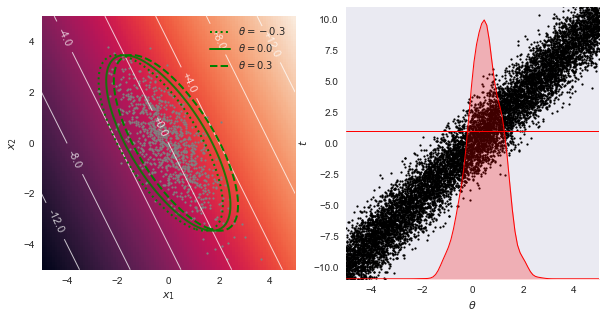

In [231]:
study(model1, 0, 0.3, -5, 5, 1, 0.2)

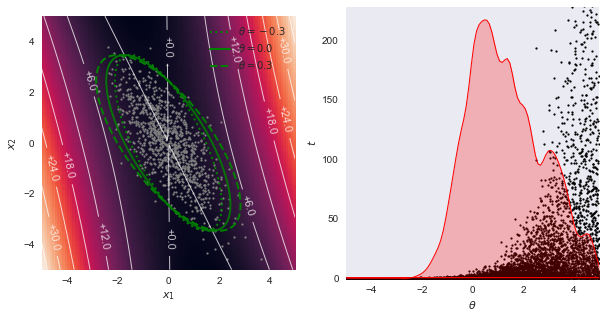

In [232]:
study(model2, 0, 0.3, -5, 5, 1, 0.2)

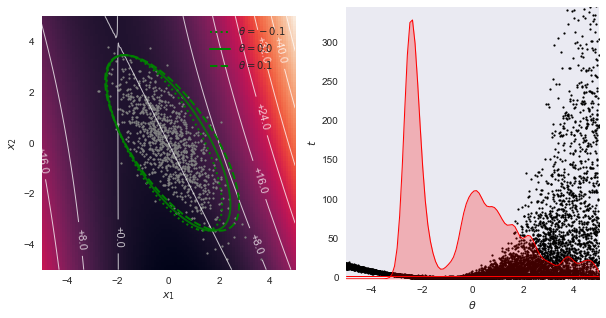

In [233]:
study(model3, 0, 0.15, -5, 5, 1, 0.2)

**TODO:**
 - Study with non-Gaussian likelihood in data inputs (using Gaussian approx vs true likelihood).
 - Study impact of true theta != theta_star used for compression: should only be loss of optimality, not a bias?

## Generate Data

We will use the same model that generated the `spectra_data` of the [dimensionality reduction]() notebook:

In [3]:
from mls import locate_data

In [4]:
spectra_data = pd.read_hdf(locate_data('spectra_data.hf5'))

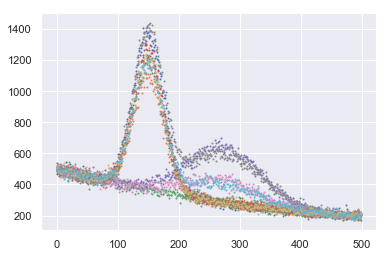

In [5]:
for i in range(10):
    plt.plot(spectra_data.iloc[i], '.', ms=2)

Each sample is a graph of a smooth function with some noise added.  The smooth function has three distinct components: 
- two peaks, with fixed locations and shapes, and normalizations that vary independently.
- a smooth background with no free parameters.
Since the data could be reproduced with just normalization parameters (except for the noise), it has an effective dimensionality of $d=2$.

Note that the relative normalization of each feature is significant here, so we would not want to normalize this data and lose this information.  We refer to each sample as a "spectrum" since it looks similar to spectra obtained in different areas of physics (astronomy, nuclear physics, particle physics, ...)

## Model-Driven Optimal Compression

Most dimensionality reduction methods assume that variance is a good proxy for "information". However, when you have a good generative model of your data, you can do much better. In particular, there is an optimal compression algorithm for data generated by a model with $n$ parameters that will reduce your whole dataset down to $n$ numbers! 

See this [Alsing 2018 paper](https://doi.org/10.1093/mnras/sty819) titled *Massive optimal data compression and density estimation for scalable, likelihood-free inference in cosmology* for the details.

To start, we need a **generative model** for our data, i.e., a python function that takes a vector of parameter values $\theta$ as input and uses random numbers to generate a **realization** $X$ of the data:

In [6]:
import scipy.stats

In [131]:
def generate_data(theta, gen, N=200, D=100, batchsize=1, noise_rms=20.):
    """Generate a random realization of the dataset.
    
    Parameters
    ----------
    theta : array
        Array of input parameters to use.
    gen : np.random.RandomState
        Random number generator to use for reproducible results.
    N : int
        Number of samples in one dataset.
    D : int
        Number of spectrum bins (features) to use for each sample.
    batchsize : int
        Number of data samples to generate in a batch.

    Returns
    -------
    array
        Array X of generated data with shape (batchsize, N, D).
    """
    # Decode model parameters.
    (x1, x2,        # peak positions
     sig1, sig2,    # peak Gaussian widths
     loc1, scale1,  # Rayleigh params for peak1 flux
     loc2, scale2,  # Rayleigh params for peak2 flux
     pk1frac,       # frac of spectra with peak 1
     pk1and2,       # frac of spectra with peak 1 that also have peak 2
     pk2only,       # frac of spectra w/o peak 1 that have peak 2
     bg0, bg1, bg2, # background shape polynomial coefs
    )= theta
    
    size = (batchsize, N)
    
    # Generate fluxes in two peaks
    x = np.linspace(0., 1., D)
    f1 = scipy.stats.rayleigh.rvs(loc=loc1, scale=scale1, size=size, random_state=gen)
    f2 = scipy.stats.rayleigh.rvs(loc=loc2, scale=scale2, size=size, random_state=gen)
    
    # pk1frac of spectra have peak 1.
    R = gen.uniform(size=size)
    p1 = R < pk1frac
    # pk1and2 of spectra with peak 1 also have peak 2.
    # pk2only of spectra without peak 1 have peak 2.
    R = gen.uniform(size=size)
    p2 = (p1 & (R < pk1and2)) | (~p1 & (R < pk2only))
    f1[~p1] = 0.
    f2[~p2] = 0.

    # A smooth background component has constant shape and normalization.
    bg = bg0 + bg1 * x + bg2 * x ** 2
    
    # Calculate normalized peak shapes.
    pk1 = np.exp(-0.5 * ((x - x1) / sig1) ** 2) / (np.sqrt(2 * np.pi) * sig1)
    pk2 = np.exp(-0.5 * ((x - x2) / sig2) ** 2) / (np.sqrt(2 * np.pi) * sig2)

    # Generate smooth spectra.
    data = bg + f1[..., np.newaxis] * pk1 + f2[..., np.newaxis] * pk2
    
    # Add constant noise fluctuations.
    data += gen.normal(scale=noise_rms)
    
    return data

In [130]:
np.sqrt(400.)

20.0

Our model has 14 parameters $\theta$ which we need to specify in order to generate data. Pick a "fiducial" reference set $\theta_\ast$ to use below:

In [105]:
theta_star=(0.30, 0.55, 0.05, 0.12, 50., 50., 20., 50., 0.5, 0.3, 0.7, 500., -500., 200.)

In [136]:
pnames = ('x1', 'x2', 'sig1', 'sig2', 'loc1', 'scale1', 'loc2', 'scale2',
          'pk1frac', 'pk1and2', 'pk2only', 'bg0', 'bg1', 'bg2')

We also need to specify a prior probability density in the parameters, which we take to be uniform:

In [132]:
theta_min=(0.25, 0.50, 0.02, 0.10, 30., 30., 15., 30., 0.2, 0., 0., 300., -450., 190.)
theta_max=(0.50, 0.75, 0.06, 0.15, 60., 60., 25., 60., 0.8, 1., 1., 600., -550., 210.)
assert np.all((theta_star >= theta_min) & (theta_star <= theta_max))

Generate samples from the parameter prior:

In [133]:
def generate_params(n, gen):
    return gen.uniform(low=theta_min, high=theta_max, size=(n, len(theta_min)))

Generate a batch of 10 realizations:

In [108]:
gen = np.random.RandomState(seed=123)

In [109]:
X = generate_data(theta_star, gen, batchsize=10)

In [110]:
X.shape

(10, 200, 100)

### Stage-1 Compression

The first stage of compression transforms a $N\times D$ dataset $X$ into a set of summary statistics $\mathbf{d}$ that contains fewer values than the $N D$ values in the original dataset $X$. Note that the map is not a dataset, in the sense that it can have an arbitrary shape (which we will ignore and flatten out) and will not have an axis corresponding to sample number (instead, each value is a summary of all samples).

For this example, we will simply calculate the mean and standard deviation of all spectra in each bin, so $X$ is compressed from $N\times D$ to $2\times D$ values:

In [111]:
Stage1 = lambda X: np.hstack([np.mean(X, axis=1), np.std(X, axis=1)])

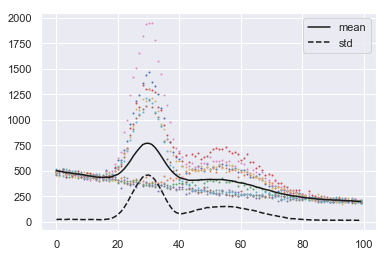

In [114]:
S1 = Stage1(X)
B, D = S1.shape
for i in range(10):
    plt.plot(X[0, i], '.', ms=2)
plt.plot(S1[0,:D//2], 'k-', label='mean')
plt.plot(S1[0,D//2:], 'k--', label='std')
plt.legend();

### Stage-2 Compression

#### Online Statistics Accumulation

Given the running estimates $(\mu_N, C_N)$ after $n$ batches with a total of $N$ samples, and estimates $(\mu, C)$ for the $n+1$-st batch of $B$ samples, the updated running estimates are:
$$
\mu_{N+B} = \mu_N + \frac{B}{N+B} \left(\mu_B - \mu_N\right)
\quad, \quad
C_{N+B} = C_N + C_B + \frac{N B}{N+B} \left(\mu_B - \mu_N\right)^T \left(\mu_N - \mu_B\right) \; ,
$$

In [39]:
class Accumulator(object):
    """Estimate the mean and covariance of data using a one-pass algorithm.
    
    Uses https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Online
    The memory requirements are fixed.
    
    See also https://doi.org/10.1145/3221269.3223036 and
    https://doi.org/10.1109/CLUSTR.2009.5289161
    """
    def __init__(self, D):
        self.mu_ = np.zeros(D)
        self.C_ = np.zeros((D, D))
        self.N_ = 0
    def accumulate(self, data, batched=False):
        data = np.asarray(data)        
        if batched:
            B = len(data)
            data = data.reshape(B, -1)
            delta = np.mean(data, axis=0) - self.mu_
            frac = B / (self.N_ + B)
            self.mu_ += frac * delta
            self.C_ += (B - 1) * np.cov(data, rowvar=False)
            self.C_ += self.N_ * frac * delta.reshape(-1, 1) * delta
            self.N_ += B
        else:
            delta = data - self.mu_
            frac = 1 / (self.N_ + 1)
            self.mu_ += frac * delta
            self.C_ += self.N_ * frac * delta.reshape(-1, 1) * delta
            self.N_ += 1
    @property
    def mu(self):
        return self.mu_
    @property
    def C(self):
        return self.C_ / (self.N_ - 1)
    @property
    def N(self):
        return self.N_

In [74]:
def test_accumulator(N=10000, B=100, seed=123):
    
    mu = np.array([-3., 2.])
    C = np.array([[2., -0.5], [-0.5, 1.]])
    gen = np.random.RandomState(seed)
    X = gen.multivariate_normal(mu, C, size=N)

    mu_all = np.mean(X, axis=0)
    C_all = np.cov(X, rowvar=False)

    S = Accumulator(2)
    for d in X:
        S.accumulate(d)
    assert np.allclose(S.N, N)
    assert np.allclose(S.mu, mu_all)
    assert np.allclose(S.C, C_all)
    
    S = Accumulator(2)
    X = X.reshape(B, N // B, 2)
    for d in X:
        S.accumulate(d, batched=True)
    assert np.allclose(S.N, N)
    assert np.allclose(S.mu, mu_all)
    assert np.allclose(S.C, C_all)
    
test_accumulator(B=1)
test_accumulator(B=10)
test_accumulator(B=100)

#### Optimal Compression

The optimally compressed variables are (from eqn (3)):
$$
\mathbf{t} = \nabla_\theta\mu_\ast^T C_\ast^{-1} \left(\mathbf{d}-\mu_\ast\right) +
\frac{1}{2} \left(\mathbf{d}-\mu_\ast\right)^T C_\ast^{-1} \nabla_\theta C_\ast
C_\ast^{-1} \left(\mathbf{d}-\mu_\ast\right) \; ,
$$
where $\mathbf{d}$ is the input data $\mathbf{D}$ after the first stage of compression, and $\mu_\ast$ and $C_\ast$ are the mean and covariance of stage-1 compressed samples with gradients $\nabla_\theta\mu_\ast$ and $\nabla_\theta C_\ast$ with respect to the generative model parameters $\theta$.  The asterisk indicates that these are evaluated at some fiducial set of parameters $\theta_\ast$.

A practical algorithm for calculating $\mu_\ast$ and $C_\ast$ and their gradients is:
```
initialize statistics accumulators
loop over trials:
  generate a random dataset d_star with theta_star
  accumulate mean and covariance statistics
  loop over parameters j in theta:
    perturb parameter j by +eps * theta_star[j]
    generate a random dataset d_plus with the perturbed parameters
```

In [115]:
class OptimalCompresser(object):
    def __init__(self, model, theta0, stage1, num_batches=10, batchsize=1000, seed=123, eps=0.005):
        gen = np.random.RandomState(seed=seed)
        # Calculate perturbed parameters.
        theta0 = np.asarray(theta0)
        thetap = theta0 * (1 + eps)
        thetam = theta0 * (1 - eps)
        # Initialize statistics.
        D0 = stage1(model(theta0, gen, batchsize=batchsize))
        B, N = D0.shape
        assert B == batchsize
        n = len(theta0)
        print(f'Compressing {num_batches} batches with shape {D0.shape} values to {n} features.')
        stats0 = Accumulator(N)
        statsp = [Accumulator(N) for j in range(n)]
        statsm = [Accumulator(N) for j in range(n)]
        # Loop over batches.
        for i in range(num_batches):
            print(i)
            D0 = stage1(model(theta0, gen, batchsize=batchsize))
            stats0.accumulate(D0, batched=True)
            # Loop over parameters to vary by +/-eps.
            for j in range(n):
                theta = theta0.copy()
                theta[j] = theta0[j] * (1 + eps)
                Dp = stage1(model(theta, gen, batchsize=batchsize))
                statsp[j].accumulate(Dp, batched=True)
                theta[j] = theta0[j] * (1 - eps)
                Dm = stage1(model(theta, gen, batchsize=batchsize))
                statsm[j].accumulate(Dm, batched=True)
        self.mu_ = stats0.mu
        self.C_ = stats0.C
        self.Cinv_ = np.linalg.inv(self.C_)
        # Estimate the gradients of mu and C using central finite differences.
        # https://en.wikipedia.org/wiki/Finite_difference_coefficient
        self.mu_grad = np.empty((n, N))
        self.C_grad = np.empty((n, N, N))
        for j in range(n):
            self.mu_grad[j] = (statsp[j].mu - statsm[j].mu) / (2 * eps * theta0[j])
            self.C_grad[j] = (statsp[j].C - statsm[j].C) / (2 * eps * theta0[j])
        # Calculate the compression coefficients.
        self.coef1_ = self.mu_grad.dot(self.Cinv_)
        self.coef2_ = self.Cinv_.dot(self.C_grad.dot(self.Cinv_))
    
    def __call__(self, data):
        delta = data.reshape(-1) - self.mu_
        return self.coef1_.dot(delta) + 0.5 * delta.T.dot(self.coef2_.dot(delta))

Initialize the optimal compression:

In [116]:
%time Stage2 = OptimalCompresser(generate_data, theta_star, Stage1, num_batches=10)

Compressing summary batches with shape (1000, 200) values to 14 features.
0
1
2
3
4
5
6
7
8
9
CPU times: user 13min 14s, sys: 1min 28s, total: 14min 43s
Wall time: 5min 42s


In [79]:
Stage2.coef1_.shape, Stage2.coef2_.shape

((14, 500), (500, 14, 500))

In [124]:
d = Stage1(generate_data(theta_star, gen, batchsize=2))

In [125]:
d.shape

(2, 200)

In [128]:
Stage2(d)

ValueError: operands could not be broadcast together with shapes (400,) (200,) 

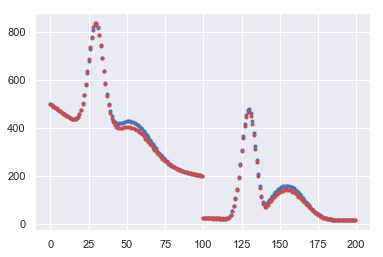

In [119]:
plt.plot(Stage2.mu_, 'b.')
plt.plot(d.reshape(-1), 'r.')

```
    (x1, x2,        # peak positions
     sig1, sig2,    # peak Gaussian widths
     loc1, scale1,  # Rayleigh params for peak1 flux
     loc2, scale2,  # Rayleigh params for peak2 flux
     pk1frac,       # frac of spectra with peak 1
     pk1and2,       # frac of spectra with peak 1 that also have peak 2
     pk2only,       # frac of spectra w/o peak 1 that have peak 2
     bg0, bg1, bg2, # background shape polynomial coefs
```

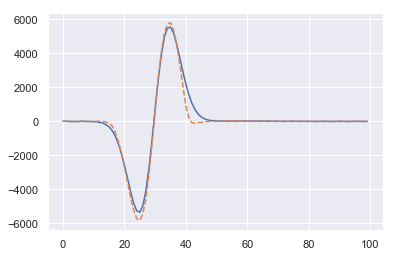

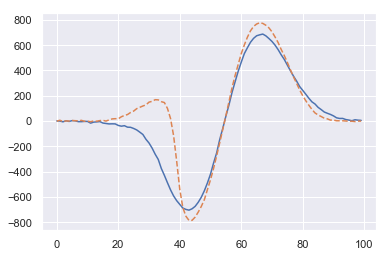

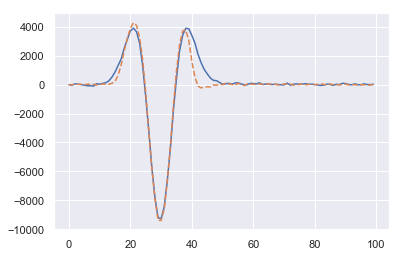

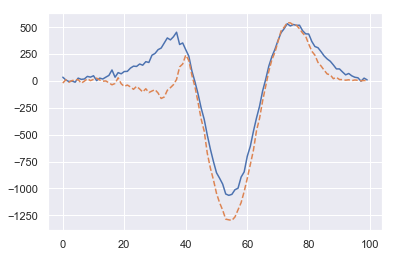

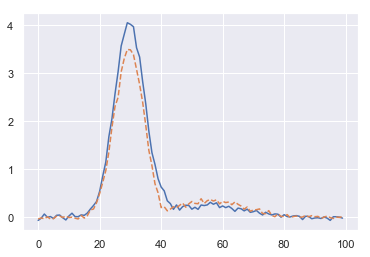

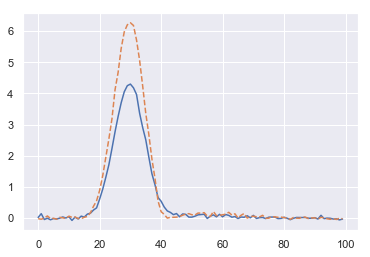

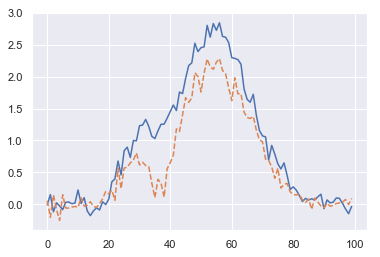

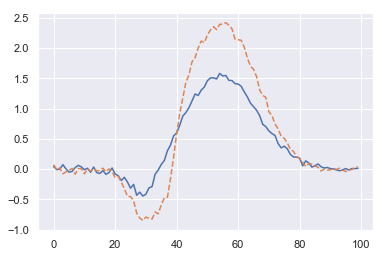

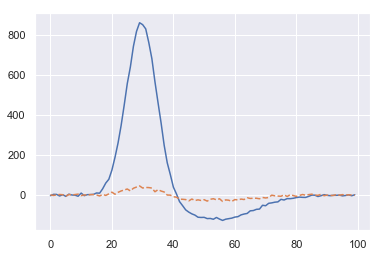

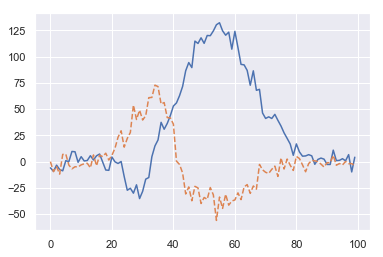

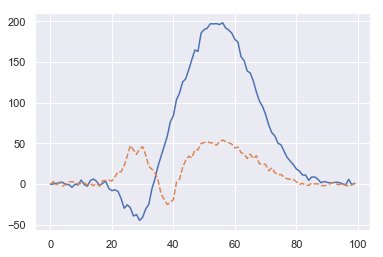

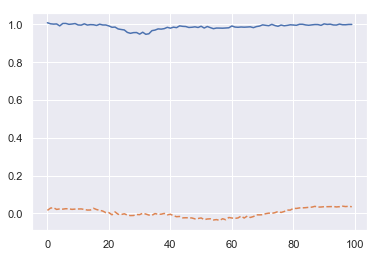

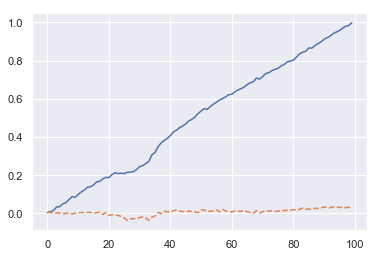

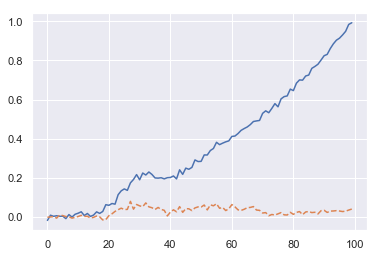

In [120]:
def plot_grads(S=Stage2):
    n, D = S.mu_grad.shape
    for i in range(n):
        plt.plot(S.mu_grad[i,:D//2], '-')
        plt.plot(S.mu_grad[i,D//2:], '--')
        plt.show()
        
plot_grads()

## Likelihood-Free Inference

To perform inference, we:
 - Simulate many realizations of the data using random parameters sampled from the prior.
 - Fit a Gaussian mixture model (GMM) of $P(\theta, d)$ to the result samples of the joint $(\theta, d)$ probability.
 - Calculate the compressed feature values for the observed data.
 - Condition the GMM on the compressed feature values, to obtain a GMM of $P(\theta\mid d)$.

The relevant equations to condition each Gaussian in the mixture model are:
$$
\mu_{\theta\mid d} = \mu_\theta + C_{\theta d} C_{dd}^{-1} \left( d - \mu_d\right) \quad, \quad
C_{\theta\mid d} = C_{\theta\theta} - C_{\theta d}C_{dd}^{-1} C_{\theta d}^T \; .
$$

In [203]:
class ABC(object):
    def __init__(self, prior, model, stage1, stage2, nsamples=100000, seed=123, n_components=15):
        self.stage1 = stage1
        self.stage2 = stage2
        gen = np.random.RandomState(seed)
        # Generate parameter values sampled from the prior.
        thetas = prior(nsamples, gen)
        _, self.nparams = thetas.shape
        # Generate data for each parameter sample.
        X = np.empty((nsamples, self.nparams))
        for i, theta in enumerate(thetas):
            X[i] = stage2(stage1(model(theta, gen, batchsize=1)))

        pnames = [f'p{k}' for k in range(self.nparams)]
        thetas = pd.DataFrame(thetas, columns=pnames)
        cnames = [f't{k}' for k in range(self.nparams)]
        compressed = pd.DataFrame(X, columns=cnames)
        self.df = pd.concat([thetas, compressed], axis=1)
        #sns.pairplot(self.df, x_vars=pnames[:5], y_vars=cnames[:5])

        # Fit a GMM to the density.
        self.fit_ = mixture.GaussianMixture(n_components=n_components).fit(self.df)
        self.wgt = self.fit_.weights_

    def fit(self, data):
        K, n = len(self.wgt), self.nparams
        # Calculate compressed variables for this data.
        d = self.stage2(self.stage1(data))
        # Condition the GMM components on the observed compressed variables.
        self.mu = np.empty((K, n))
        self.C = np.empty((K, n, n))
        for i in range(K):
            mu_full = self.fit_.means_[i]
            mu_th, mu_d = mu_full[:n], mu_full[ n:]
            C_full = self.fit_.covariances_[i]
            C_th_th, C_th_d, C_d_d = C_full[:n, :n], C_full[:n, n:], C_full[n:, n:]
            C_d_d_inv = np.linalg.inv(C_d_d)
            CC = C_th_d.dot(C_d_d_inv)
            self.mu[i] = mu_th + CC.dot(d - mu_d)
            self.C[i] = C_th_th + CC.dot(C_th_d.T)

In [204]:
%time abc = ABC(generate_params, generate_data, Stage1, Stage2)

CPU times: user 6min 30s, sys: 9.93 s, total: 6min 40s
Wall time: 2min 14s


In [205]:
X = generate_data(theta_star, gen)
abc.fit(X)

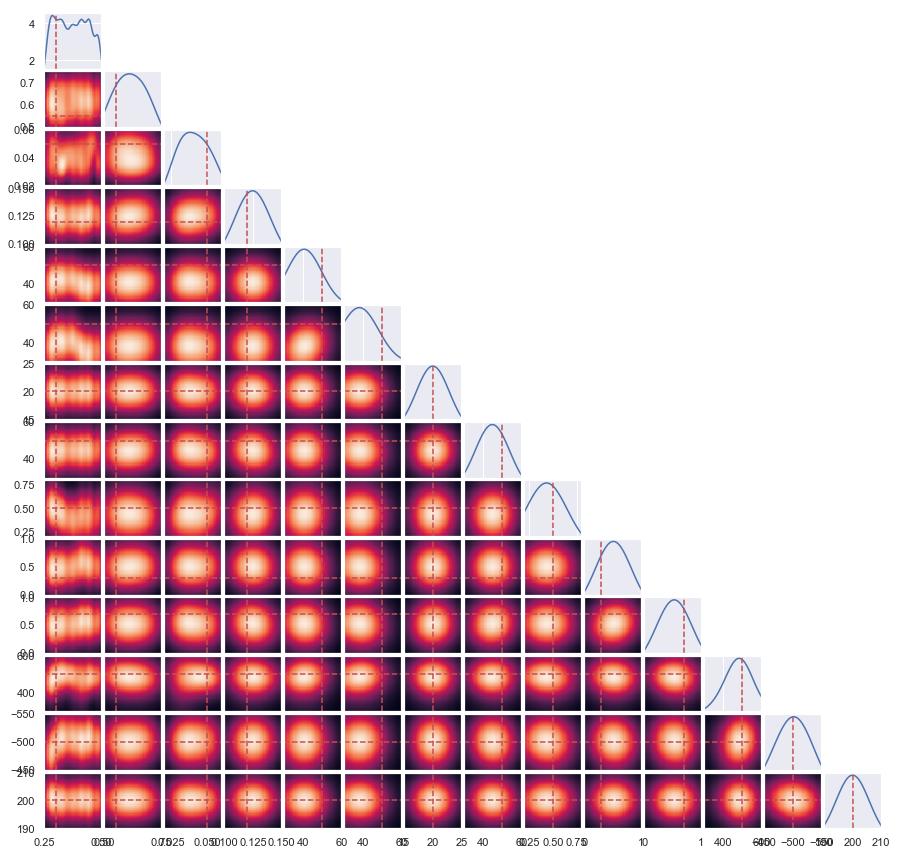

In [244]:
def plot(self, ngrid=50):
    K, n = len(self.wgt), self.nparams
    #n = 5
    fig, axes = plt.subplots(n, n, figsize=(15, 15), sharex='col')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    for i in range(n):
        ax = axes[i, i]
        x1 = np.linspace(theta_min[i], theta_max[i], ngrid)
        y = np.zeros(ngrid)
        for k in range(K):
            y += self.wgt[k] * scipy.stats.norm.pdf(x1, self.mu[k, i], np.sqrt(self.C[k, i, i]))
        ax.plot(x1, y)
        ax.set_xlim(x1[0], x1[-1])
        ax.axvline(theta_star[i], c='r', ls='--')
        for j in range(n):
            ax = axes[i, j]
            if j > 0:
                ax.set_yticks([])
            if j >= i:
                if j > i: ax.axis('off')
                continue
            x2 = np.linspace(theta_min[j], theta_max[j], 50)
            y = np.zeros((ngrid, ngrid))
            x12 = np.empty((ngrid, ngrid, 2))
            x12[:, :, 0] = x1.reshape(-1, 1)
            x12[:, :, 1] = x2
            for k in range(K):
                y += self.wgt[k] * scipy.stats.multivariate_normal.pdf(
                    x12, self.mu[k, [i,j]], self.C[k, [[i], [j]], [[i, j]]])
            ax.imshow(y, interpolation='none', origin='lower',
                      extent=(x2[0], x2[-1], x1[0], x1[-1]), aspect='auto')
            ax.grid(False)
            ax.axvline(theta_star[j], c='r', ls='--')
            ax.axhline(theta_star[i], c='r', ls='--')
    
plot(abc)